In [1]:
import os
import uuid
import glob 
import torch
import torch.nn as nn
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image
from maskrcnn_benchmark.config import cfg
import matplotlib.pyplot as plt
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer

%load_ext autoreload
%autoreload 2

In [2]:
cfg.merge_from_file('configs/garment_detection-1gpu.yaml')
cfg.merge_from_list(['MODEL.WEIGHT', '/data/logs/garment_detection/imaterialist+modanet_continue/model_0047500.pth'])
cfg.merge_from_list(['DATALOADER.ASPECT_RATIO_GROUPING', 'False'])
cfg.merge_from_list(['TEST.IMS_PER_BATCH', '2'])
device = torch.device(cfg.MODEL.DEVICE)
cfg_ = cfg.clone()
    
model = build_detection_model(cfg_)
model.to(device)
model.eval()

checkpointer = DetectronCheckpointer(cfg_, model)
_ = checkpointer.load(cfg.MODEL.WEIGHT)

In [35]:
class EmbeddingNet(torch.nn.Module) :
    def __init__(self):
        """
        Arguments:
            num_classes (int): number of output classes
            input_size (int): number of channels of the input once it's flattened
            representation_size (int): size of the intermediate representation
        """
        super(EmbeddingNet, self).__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.ReLU()
        )

        self.embedding = nn.Sequential(
            nn.Linear(7*7*256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )

        self.downsample.cuda()
        self.embedding.cuda()

    def forward(self, features) :
        embedding_input = self.downsample(features)
        embedding_input = embedding_input.view(-1, 7*7*256) # flatten
        embedding = self.embedding(embedding_input)

        l2norm = torch.norm(embedding, p=2, dim=1, keepdim=True)
        embedding_l2norm = embedding.div(l2norm.expand_as(embedding))
        return embedding_l2norm

embedding_net = EmbeddingNet()
            
def filter_detections(detections, features) :
    detections_, features_ = [], []
    for detection, feature in zip(detections, features) :
        scores = detection.get_field("scores")
        keep = torch.nonzero(scores > 0.7).squeeze(1)

        detection = detection[keep]
        feature = feature[keep]

        scores = detection.get_field("scores")
        _, idx = scores.sort(0, descending=True)

        detection = detection[idx]
        feature = feature[idx]

        # also filter out redundant classes
        labels = detection.get_field("labels").cpu().numpy().tolist()
        uq_labels = list(set(labels))
        label_idx = [labels.index(l) for l in uq_labels]

        detection = detection[label_idx]
        feature = feature[label_idx]

        assert(len(detection)==feature.shape[0])
        
        detections_.append(detection)
        features_.append(feature)
    return detections_, features_

In [4]:
from maskrcnn_benchmark.data import make_data_loader
data_loader = make_data_loader(
    cfg,
    is_train=False,
    is_distributed=False,
)[0]
data_loader_iter = iter(data_loader)

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


In [5]:
def split_feats_by_image(detections, features) :
    ndetect_per_image = list(map(len, detections))
    end_ixes = np.cumsum(ndetect_per_image)
    features_ = []
    for ix in range(len(ndetect_per_image)) : 
        if ix == 0 :
            features_.append(features[0:end_ixes[0]])
        else :
            features_.append(features[end_ixes[ix-1]:end_ixes[ix], :])
        assert(features_[ix].shape[0]==ndetect_per_image[ix])
    return features_

In [6]:
batch = next(data_loader_iter)
garment, models, categoryids = batch[0], batch[1], batch[2]
garment = garment.to(device)
models = models.to(device)

In [7]:
garment_detections, garment_features = model(garment) # detections is a boxlist, features is a tensor
model_detections, model_features = model(models)

In [8]:
garment_features = split_feats_by_image(garment_detections, garment_features) # list of tensors
model_features = split_feats_by_image(model_detections, model_features)

garment_detections, garment_features = filter_detections(garment_detections, garment_features)
model_detections, model_features = filter_detections(model_detections, model_features)

In [66]:
def match_detections_with_gt(garment_detections, model_detections, 
                             garment_features, model_features, labels) :
    
    # only keep scores above .7
    assert(len(garment_detections)==len(model_detections))
    assert(len(garment_detections)==len(labels)) # number of images 
    
    features = torch.Tensor().cuda()
    
    labels_ = []
    next_id = 0
    # loop over number of images
    for ix in range(len(labels)) :
        label = labels[ix]
        garment_detection, model_detection = garment_detections[ix], model_detections[ix] 
        garment_feature, model_feature = garment_features[ix], model_features[ix]
        
        garment_labels = garment_detection.get_field('labels').cpu().numpy().tolist()
        model_labels = model_detection.get_field('labels').cpu().numpy().tolist()
        
        prediction_match = label in garment_labels and \
                            label in model_labels
        
        if prediction_match : 
            labels_ += [next_id, next_id]
            next_id += 1
            
            garment_idx = garment_labels.index(label)
            model_idx = model_labels.index(label)
            
            features = torch.cat((features, garment_feature[garment_idx].unsqueeze(0)))
            features = torch.cat((features, model_feature[model_idx].unsqueeze(0)))
            
        for lbl_ix, lbl in enumerate(garment_labels) :
            if prediction_match and lbl == label :
                continue
            features = torch.cat((features, garment_feature[lbl_ix].unsqueeze(0)))
            labels_.append(next_id)
            next_id += 1

        for lbl_ix, lbl in enumerate(model_labels) :
            if prediction_match and lbl == label :
                continue
            features = torch.cat((features, model_feature[lbl_ix].unsqueeze(0)))
            labels_.append(next_id)
            next_id += 1
                
    return features, labels_

In [63]:
features, labels = match_detections_with_gt(garment_detections, model_detections, garment_features, model_features, categoryids)

In [67]:
embeddings = embedding_net(features)

In [19]:
means = [102.9801, 115.9465, 122.7717]
stds = [1., 1., 1.]
def undo_transforms(anchor) :
    anchor = anchor.numpy().copy()
    for c_ix in range(3) :
        mean, std = means[c_ix], stds[c_ix]
        anchor[c_ix, :, :] = anchor[c_ix, :, :]*std + mean
    anchor = anchor.astype(np.uint8)
    anchor = np.moveaxis(anchor, 0, 2)
    anchor = anchor[:, :, ::-1]
    return Image.fromarray(anchor)

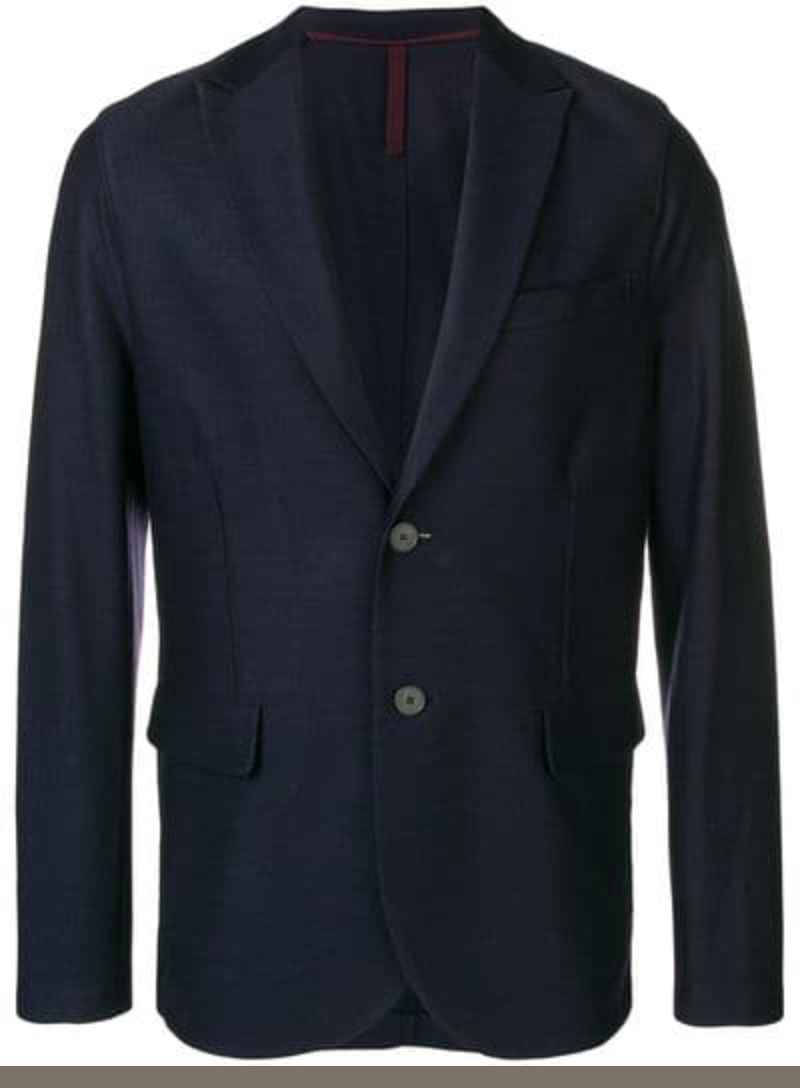

In [29]:
undo_transforms(garment.tensors.cpu()[0].squeeze(0))